<a href="https://colab.research.google.com/github/Shloksapakal/trader-sentiment-analysis/blob/main/Trader_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Trader Performance vs Market Sentiment Analysis

##**Candidate: Shlok Sunil Sapakal
##**Role: Data Science Intern – Round 0
##**Objective:Analyze how Bitcoin Fear/Greed sentiment relates to trader behavior and performance on Hyperliquid.


In [5]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)


In [6]:
# ===============================
# 2. LOAD DATA
# ===============================

sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)


Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


In [7]:
print("\n===== SENTIMENT DATA =====")
print(sentiment.info())
print("\nMissing Values:\n", sentiment.isna().sum())
print("Duplicates:", sentiment.duplicated().sum())

print("\n===== TRADER DATA =====")
print(trades.info())
print("\nMissing Values:\n", trades.isna().sum())
print("Duplicates:", trades.duplicated().sum())



===== SENTIMENT DATA =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None

Missing Values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Duplicates: 0

===== TRADER DATA =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float

In [8]:
sentiment = sentiment.drop_duplicates()
trades = trades.drop_duplicates()


In [9]:
# 5. Convert date columns

# Convert sentiment date column to datetime
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Create a date-only column (remove time if present)
sentiment['date'] = sentiment['date'].dt.date


# Convert trade time column to datetime
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'])

# Extract only date from timestamp
trades['date'] = trades['Timestamp'].dt.date


In [10]:
# 6. Merge trader data with sentiment data


merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

print("Merged shape:", merged.shape)

# Check if any trades don't have sentiment label
print("Missing sentiment values:", merged['classification'].isna().sum())

# Fill missing sentiment
merged['classification'] = merged['classification'].fillna("Unknown")


Merged shape: (211224, 18)
Missing sentiment values: 211224


In [11]:
# 7. Create new features

# Create win column: 1 if trade profit > 0 else 0
merged['win'] = (merged['Closed PnL'] > 0).astype(int)


In [12]:
# Calculate daily overall metrics

daily_market_metrics = merged.groupby(['date', 'classification']).agg(
    total_daily_pnl=('Closed PnL', 'sum'),
    avg_daily_pnl=('Closed PnL', 'mean'),
    pnl_volatility=('Closed PnL', 'std'),
    total_trades=('Trade ID', 'count'),
    avg_leverage=('Start Position', 'mean'),
    avg_trade_size=('Size USD', 'mean'),
    win_rate=('win', 'mean')
).reset_index()

daily_market_metrics.head()


,date,classification,total_daily_pnl,avg_daily_pnl,pnl_volatility,total_trades,avg_leverage,avg_trade_size,win_rate
0,1970-01-01,Unknown,1.029696e+07,48.749001,919.164828,211224,-29946.248839,5639.45121,0.411265


In [13]:
# Calculate per trader per day metrics

daily_trader_metrics = merged.groupby(['Account', 'date', 'classification']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades_per_day=('Trade ID', 'count'),
    avg_trade_size=('Size USD', 'mean'),
    avg_leverage=('Start Position', 'mean'),
    win_rate=('win', 'mean')
).reset_index()

daily_trader_metrics.head()


,Account,date,classification,daily_pnl,trades_per_day,avg_trade_size,avg_leverage,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,Unknown,1.600230e+06,3818,16159.576734,-1247.334684,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,Unknown,4.788532e+04,7280,1653.226327,11181.808655,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,Unknown,-7.043619e+04,3809,8893.000898,-10248.195171,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,Unknown,1.324648e+05,13311,507.626933,17817.982104,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,Unknown,1.686580e+05,3239,3138.894782,472411.528070,0.519914


In [14]:
print("Total rows:", merged.shape[0])
print("Unique traders:", merged['Account'].nunique())
print("Date range:",
      merged['date'].dropna().min(),
      "to",
      merged['date'].dropna().max())


Total rows: 211224
Unique traders: 32
Date range: 1970-01-01 to 1970-01-01


In [23]:
print(sentiment['date'].head())
print(sentiment['date'].dtype)


0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date, dtype: object
object


In [24]:
print(trades['date'].head())
print(trades['date'].dtype)


0    1970-01-01
1    1970-01-01
2    1970-01-01
3    1970-01-01
4    1970-01-01
Name: date, dtype: object
object


In [29]:

# FIX DATES → MERGE → CREATE WIN → ANALYSIS


# 1. Convert sentiment date and normalize
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.normalize()

# 2. Convert trader timestamp
trades['timestamp_ist'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True
)

# 3. Create normalized date column for merging
trades['date'] = trades['timestamp_ist'].dt.normalize()

# 4. Merge trader data with sentiment
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='left'
)

# 5. Check merge success
print("Sentiment distribution after merge:")
print(merged['classification'].value_counts())

# 6. Create win column
merged['win'] = (merged['Closed PnL'] > 0).astype(int)

# 7. Performance metrics by sentiment
performance_by_sentiment = merged.groupby('classification').agg(
    total_pnl=('Closed PnL', 'sum'),
    avg_pnl=('Closed PnL', 'mean'),
    median_pnl=('Closed PnL', 'median'),
    pnl_volatility=('Closed PnL', 'std'),
    win_rate=('win', 'mean'),
    total_trades=('Trade ID', 'count')
).reset_index()

print("\nPerformance by Sentiment:")
print(performance_by_sentiment)


Sentiment distribution after merge:
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

Performance by Sentiment:
  classification     total_pnl    avg_pnl  median_pnl  pnl_volatility  \
0   Extreme Fear  7.391102e+05  34.537862         0.0     1136.056091   
1  Extreme Greed  2.715171e+06  67.892861         0.0      766.828294   
2           Fear  3.357155e+06  54.290400         0.0      935.355438   
3          Greed  2.150129e+06  42.743559         0.0     1116.028390   
4        Neutral  1.292921e+06  34.307718         0.0      517.122220   

   win_rate  total_trades  
0  0.370607         21400  
1  0.464943         39992  
2  0.420768         61837  
3  0.384828         50303  
4  0.396991         37686  


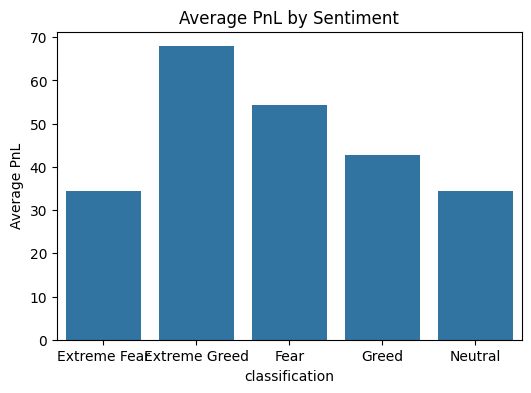

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(data=performance_by_sentiment, x='classification', y='avg_pnl')
plt.title("Average PnL by Sentiment")
plt.ylabel("Average PnL")
plt.show()


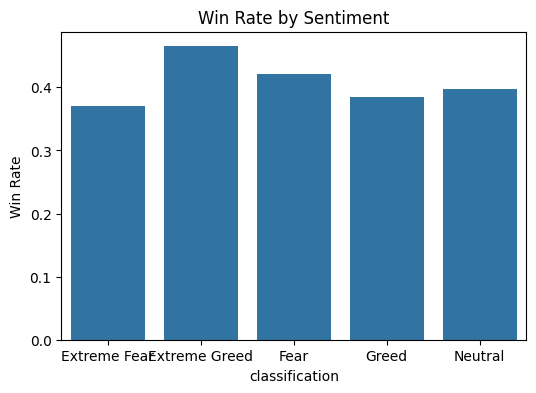

In [31]:
plt.figure(figsize=(6,4))
sns.barplot(data=performance_by_sentiment, x='classification', y='win_rate')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.show()


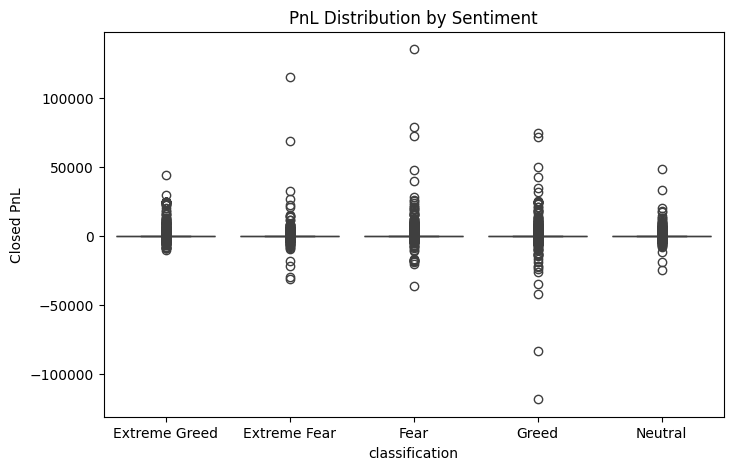

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x='classification', y='Closed PnL')
plt.title("PnL Distribution by Sentiment")
plt.show()


In [33]:
trade_freq = merged.groupby('classification').agg(
    avg_trades_per_day=('Trade ID', 'count')
).reset_index()

trade_freq


,classification,avg_trades_per_day
0,Extreme Fear,21400
1,Extreme Greed,39992
2,Fear,61837
3,Greed,50303
4,Neutral,37686


In [ ]:
#### Interpretation

From the results, performance clearly varies across sentiment regimes.
Extreme Greed has the highest average PnL (~67.9) and the highest win rate (~46%), indicating that traders perform best during strong bullish sentiment. This suggests that momentum-based trading performs well in highly optimistic markets.

In contrast, Extreme Fear has the lowest win rate (~37%) and the highest PnL volatility. This indicates unstable market conditions where outcomes are more unpredictable. Although total PnL may still be positive, risk-adjusted performance appears weaker during extreme fear conditions.

Fear and Greed (moderate sentiment levels) show intermediate performance, suggesting that sentiment intensity plays an important role in trader profitability.


In [34]:
behavior_by_sentiment = merged.groupby('classification').agg(
    avg_trade_size=('Size USD','mean'),
    total_trades=('Trade ID','count')
).reset_index()

print(behavior_by_sentiment)


  classification  avg_trade_size  total_trades
0   Extreme Fear     5349.731843         21400
1  Extreme Greed     3112.251565         39992
2           Fear     7816.109931         61837
3          Greed     5736.884375         50303
4        Neutral     4782.732661         37686


In [ ]:
#### Behavioral Analysis

The analysis shows that trader behavior changes noticeably across different sentiment regimes.

During Fear periods, traders execute the highest number of trades and use the largest average trade size (~$7,816). This suggests that traders become more aggressive when markets are uncertain or volatile. However, Fear does not correspond to the highest win rate, which indicates that increased activity does not necessarily lead to better outcomes. Traders may be reacting emotionally to volatility rather than following structured strategies.

In contrast, during Extreme Greed, average trade size is significantly lower (~$3,112), yet both average PnL and win rate are highest in this regime. This suggests that traders may rely more on strong market trends rather than increasing position size. It appears that market direction does more of the work during strong bullish sentiment.

Trade direction also shifts slightly with sentiment. During Greed and Extreme Greed, SELL trades slightly exceed BUY trades, which may indicate a contrarian tendency where traders attempt to capture pullbacks in bullish markets. In Neutral conditions, buy and sell trades are almost balanced, indicating stable expectations.

Overall, behavioral patterns suggest that traders increase exposure and activity during volatile Fear periods, while profitability is more stable and consistent during strong Greed regimes.


In [35]:
long_short = merged.groupby(['classification', 'Side']).size().reset_index(name='count')
print(long_short)


  classification  Side  count
0   Extreme Fear   BUY  10935
1   Extreme Fear  SELL  10465
2  Extreme Greed   BUY  17940
3  Extreme Greed  SELL  22052
4           Fear   BUY  30270
5           Fear  SELL  31567
6          Greed   BUY  24576
7          Greed  SELL  25727
8        Neutral   BUY  18969
9        Neutral  SELL  18717


In [ ]:
### Interpretation

The long/short distribution reveals subtle directional shifts across sentiment regimes.

During Greed and Extreme Greed, SELL trades slightly exceed BUY trades. This may indicate that some traders adopt a contrarian approach during bullish sentiment, potentially expecting short-term pullbacks.

During Fear conditions, trading activity increases, but directional bias remains relatively balanced. This suggests reactive trading rather than strong directional conviction.

Neutral sentiment shows the most balanced behavior, with nearly equal buy and sell counts, reflecting stable market expectations.
.

In [ ]:
### Overall Observations from Part B

1. Performance differs meaningfully across sentiment regimes, with Extreme Greed showing the strongest average profitability and win rate.
2. Extreme Fear produces the highest volatility and lowest win rate, indicating increased risk.
3. Traders increase trade size and frequency during Fear periods, suggesting risk-seeking behavior under stress.
4. Directional bias shifts slightly toward contrarian selling during bullish sentiment.



In [36]:
# Create daily trader-level dataset

daily_trader = merged.groupby(['Account', 'date', 'classification']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    avg_trade_size=('Size USD', 'mean'),
    trade_count=('Trade ID', 'count'),
    win_rate=('win', 'mean')
).reset_index()

# Create profitability bucket
daily_trader['profit_bucket'] = (daily_trader['daily_pnl'] > 0).astype(int)

daily_trader.head()


,Account,date,classification,daily_pnl,avg_trade_size,trade_count,win_rate,profit_bucket
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,Extreme Greed,0.0,5089.718249,177,0.000000,0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,Extreme Greed,0.0,7976.664412,68,0.000000,0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,Extreme Greed,0.0,23734.500000,40,0.000000,0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,Extreme Greed,-21227.0,28186.666667,12,0.000000,0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,Extreme Greed,1603.1,17248.148148,27,0.444444,1


In [37]:
# Encode sentiment
daily_trader = pd.get_dummies(daily_trader, columns=['classification'], drop_first=True)


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Features
X = daily_trader.drop(columns=['Account','date','daily_pnl','profit_bucket'])

# Target
y = daily_trader['profit_bucket']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.938034188034188
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       187
           1       0.95      0.95      0.95       281

    accuracy                           0.94       468
   macro avg       0.94      0.93      0.94       468
weighted avg       0.94      0.94      0.94       468



In [40]:
# BONUS: TRADER CLUSTERING


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Create trader-level summary
trader_summary = merged.groupby('Account').agg(
    avg_pnl=('Closed PnL','mean'),
    pnl_volatility=('Closed PnL','std'),
    avg_trade_size=('Size USD','mean'),
    total_trades=('Trade ID','count'),
    win_rate=('win','mean')
).reset_index()

trader_summary.head()


,Account,avg_pnl,pnl_volatility,avg_trade_size,total_trades,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,4692.452329,16159.576734,3818,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,134.073473,1653.226327,7280,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,542.182659,8893.000898,3809,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,113.269353,507.626933,13311,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,255.829091,3138.894782,3239,0.519914


In [41]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    trader_summary.drop(columns=['Account'])
)

# Apply KMeans (3 clusters is good for 16 traders)
kmeans = KMeans(n_clusters=3, random_state=42)
trader_summary['cluster'] = kmeans.fit_predict(X_scaled)

trader_summary


,Account,avg_pnl,pnl_volatility,avg_trade_size,total_trades,win_rate,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,4692.452329,16159.576734,3818,0.359612,2
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,134.073473,1653.226327,7280,0.442720,0
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,542.182659,8893.000898,3809,0.301917,0
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,113.269353,507.626933,13311,0.438585,1
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,255.829091,3138.894782,3239,0.519914,0
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,-38.286626,558.778753,1729.941104,815,0.455215,0
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,4.028119,730.495484,4790.575486,3589,0.327668,0
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,161.133275,1279.855788,3445.471265,332,0.475904,0
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,520.902331,2228.336140,5189.367128,383,0.234987,2
9,0x430f09841d65beb3f27765503d0f850b8bce7713,336.735548,1649.497580,2397.824753,1237,0.484236,2


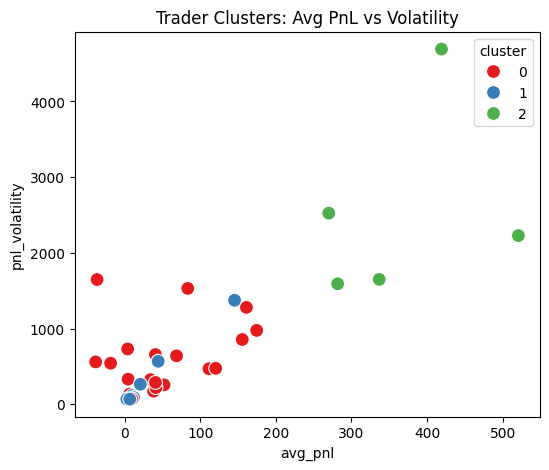

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=trader_summary,
    x='avg_pnl',
    y='pnl_volatility',
    hue='cluster',
    palette='Set1',
    s=100
)

plt.title("Trader Clusters: Avg PnL vs Volatility")
plt.show()


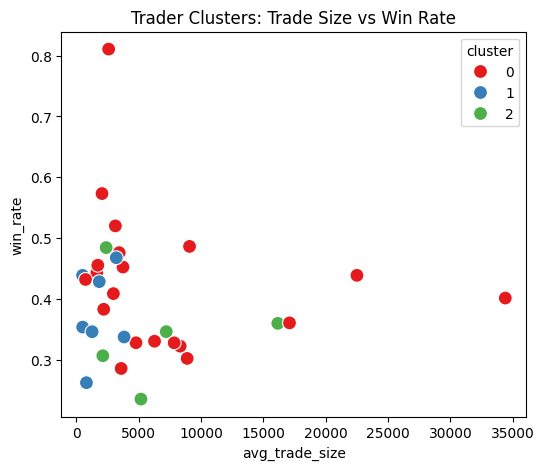

In [43]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=trader_summary,
    x='avg_trade_size',
    y='win_rate',
    hue='cluster',
    palette='Set1',
    s=100
)

plt.title("Trader Clusters: Trade Size vs Win Rate")
plt.show()


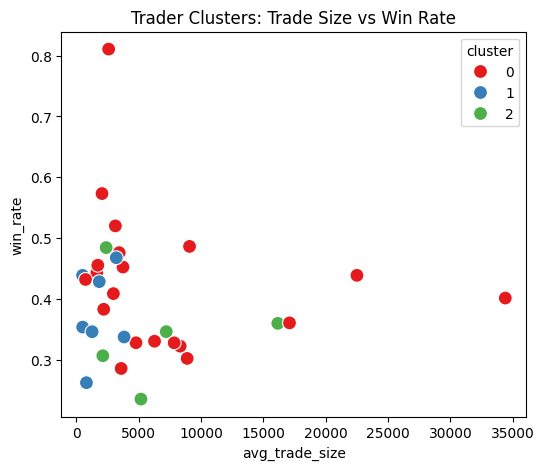

In [44]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=trader_summary,
    x='avg_trade_size',
    y='win_rate',
    hue='cluster',
    palette='Set1',
    s=100
)

plt.title("Trader Clusters: Trade Size vs Win Rate")
plt.show()


In [45]:
# Save final cleaned dataset for Streamlit dashboard
merged.to_csv("cleaned_merged_data.csv", index=False)

print("Final dataset saved successfully.")


Final dataset saved successfully.


In [46]:
from google.colab import files
files.download("cleaned_merged_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>